In [30]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout


from art.attacks.poisoning.perturbations.image_perturbations import add_pattern_bd
from art.estimators.classification import KerasClassifier
from art.utils import load_mnist, preprocess
from art.defences.detector.poison import ActivationDefence

import numpy as np
import matplotlib.pyplot as pyplot
import json as js

POIZON_PERCENT = 0.10
DATASET_SIZE = 5000


In [31]:
def get_dataset(size):
    (data, labels), (data_test, labels_test), mn, mx = load_mnist(raw=True)
    orig_size = np.shape(data)[0]
    rnd_indixeses = np.random.choice(orig_size, size)
    data = data[rnd_indixeses]
    labels = labels[rnd_indixeses]
    return data, labels, data_test, labels_test, mn, mx


def poizon_data(data, labels, perc, sources=np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), targets=np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 0])):

    pois_data = np.copy(data)
    pois_labels = np.copy(labels)
    mask_poison = np.zeros(np.shape(pois_labels))

    for (source, target) in zip(sources, targets):
        num_images_to_pois = round((perc * np.shape(data[labels == target])[0]) / (1 - perc)) 

        source_images = data[labels == source]
        num_images_in_source = np.shape(source_images)[0]
        indices_to_be_poisoned = np.random.choice(num_images_in_source, num_images_to_pois)

        imgs_to_be_poisoned = np.copy(source_images[indices_to_be_poisoned])
        imgs_to_be_poisoned = add_pattern_bd(x=imgs_to_be_poisoned, pixel_value=np.max(data))

        pois_data = np.append(pois_data, imgs_to_be_poisoned, axis=0)
        pois_labels = np.append(pois_labels, np.full(num_images_to_pois, target), axis=0)

        mask_poison = np.append(mask_poison, np.ones(num_images_to_pois))

    mask_poison = mask_poison != 0

    n_train = np.shape(pois_labels)[0]
    shuffled_indices = np.arange(n_train)
    np.random.shuffle(shuffled_indices)
    pois_data = pois_data[shuffled_indices]
    pois_labels = pois_labels[shuffled_indices]
    mask_poison = mask_poison[shuffled_indices]

    return mask_poison, pois_data, pois_labels


def preprocess_data(data, labels):
    pre_data, pre_labels = preprocess(data, labels)
    pre_data = np.expand_dims(pre_data, axis=3)
    return pre_data, pre_labels

def show_data(narr):
    num_images = len(narr)

    rows = int(np.ceil(np.sqrt(num_images)))
    cols = int(np.ceil(num_images / rows))

    fig = pyplot.figure(figsize=(6, 6))

    for i in range(num_images):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.imshow(narr[i], cmap='gray')
        ax.axis('off')

    pyplot.show()

def get_model(input_data):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=input_data.shape[1:]))
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

def eval_classifier_on_data(classifier, preprocessed_data, preprocessed_labels):
    predictions_of_classifier = np.argmax(classifier.predict(preprocessed_data), axis=1)
    accuracy = np.sum(predictions_of_classifier == np.argmax(preprocessed_labels, axis=1)) / preprocessed_data.shape[0]
    return accuracy


In [32]:
data, labels, data_test, labels_test, mn, mx = get_dataset(DATASET_SIZE)

map_poison, poiz_data, poiz_labels = poizon_data(data, labels, POIZON_PERCENT)
map_poison_test, poiz_data_test, poiz_labels_test = poizon_data(data_test, labels_test, 0.50)

# map_poison, poiz_data, poiz_labels = poizon_data(data, labels, POIZON_PERCENT, np.array([9, 2]), np.array([1, 4]))
# map_poison_test, poiz_data_test, poiz_labels_test = poizon_data(data_test, labels_test, 0.50, np.array([9, 2]), np.array([1, 4]))

p_poiz_data, p_poiz_labels = preprocess_data(poiz_data, poiz_labels)
p_poiz_data_test, p_poiz_labels_test = preprocess_data(poiz_data_test, poiz_labels_test)


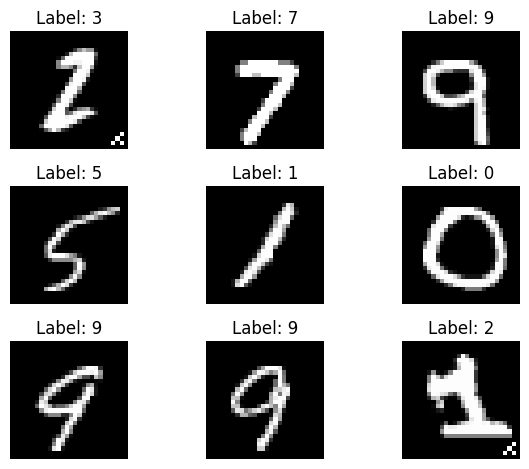

In [33]:
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(poiz_data[i], cmap=pyplot.get_cmap('gray'))
    pyplot.title("Label: {}".format(int(poiz_labels[i])))  
    pyplot.axis('off')  
pyplot.tight_layout()
pyplot.show()

In [34]:
model = get_model(p_poiz_data)

classifier = KerasClassifier(model=model, clip_values=(mn, mx))

classifier.fit(p_poiz_data, p_poiz_labels, nb_epochs=20, batch_size=128)


Train on 5555 samples
Epoch 1/20
5555/5555 [==============================] - 5s 865us/sample - loss: 1.2756 - accuracy: 0.6236
Epoch 2/20
5555/5555 [==============================] - 5s 852us/sample - loss: 0.6348 - accuracy: 0.8067
Epoch 3/20
5555/5555 [==============================] - 5s 835us/sample - loss: 0.3809 - accuracy: 0.8677
Epoch 4/20
5555/5555 [==============================] - 5s 812us/sample - loss: 0.2947 - accuracy: 0.8950
Epoch 5/20
5555/5555 [==============================] - 5s 816us/sample - loss: 0.2433 - accuracy: 0.9140
Epoch 6/20
5555/5555 [==============================] - 5s 816us/sample - loss: 0.2010 - accuracy: 0.9359
Epoch 7/20
5555/5555 [==============================] - 4s 789us/sample - loss: 0.1697 - accuracy: 0.9451
Epoch 8/20
5555/5555 [==============================] - 4s 780us/sample - loss: 0.1351 - accuracy: 0.9557
Epoch 9/20
5555/5555 [==============================] - 4s 784us/sample - loss: 0.1186 - accuracy: 0.9620
Epoch 10/20
5555/5555 [=

In [35]:
acc_poiz = eval_classifier_on_data(classifier, p_poiz_data_test[map_poison_test], p_poiz_labels_test[map_poison_test])
print(f"\nТочность на отправленных данных: {acc_poiz * 100}%")

acc_clean = eval_classifier_on_data(classifier, p_poiz_data_test[map_poison_test == 0], p_poiz_labels_test[map_poison_test == 0])
print(f"\nТочность на чистых данных: {acc_clean * 100}%", )


Точность на отправленных данных: 93.32000000000001%

Точность на чистых данных: 97.69%


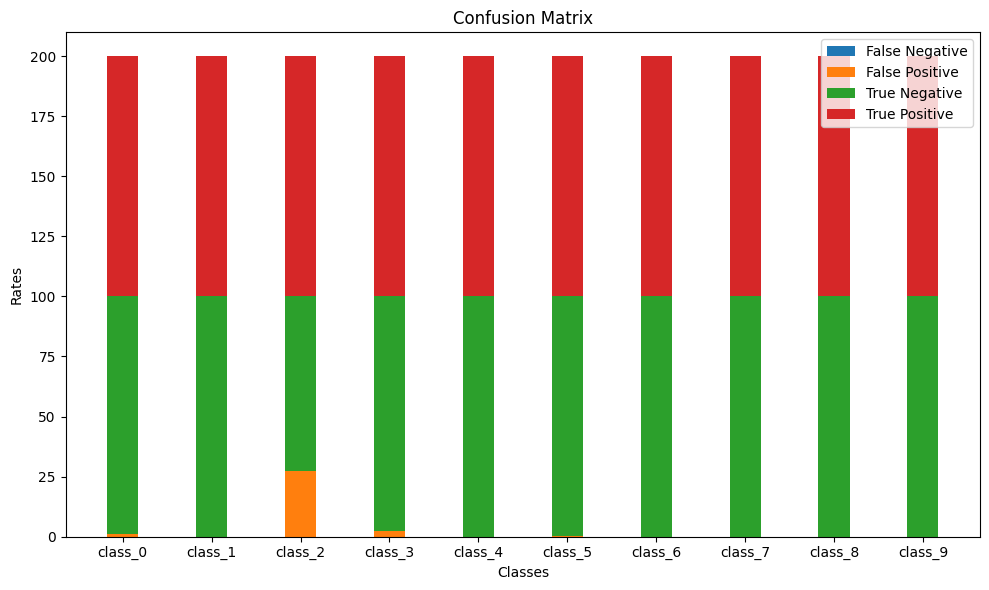

In [36]:
defence = ActivationDefence(classifier, p_poiz_data, p_poiz_labels)
_, report = defence.detect_poison()

is_clean = map_poison == 0

confusion_matrix = defence.evaluate_defence(is_clean)

# код для отображения confusion_matrix
# import pprint
# jsonObject = js.loads(confusion_matrix)
# for label in jsonObject:
#     print(label)
#     pprint.pprint(jsonObject[label])

data = js.loads(confusion_matrix)

classes = []
false_negative = []
false_positive = []
true_negative = []
true_positive = []

for class_name, class_data in data.items():
    classes.append(class_name)
    fn_rate = class_data['FalseNegative']['rate']
    fp_rate = class_data['FalsePositive']['rate']
    tn_rate = class_data['TrueNegative']['rate']
    tp_rate = class_data['TruePositive']['rate']
    fn_rate = str(fn_rate) if fn_rate != 'N/A' else '0.0'
    fp_rate = str(fp_rate) if fp_rate != 'N/A' else '0.0'
    tn_rate = str(tn_rate) if tn_rate != 'N/A' else '0.0'
    tp_rate = str(tp_rate) if tp_rate != 'N/A' else '0.0'
    false_negative.append(float(fn_rate))  # Convert to float for plotting
    false_positive.append(float(fp_rate))
    true_negative.append(float(tn_rate))
    true_positive.append(float(tp_rate))

fig, ax = pyplot.subplots(figsize=(10, 6))

bar_width = 0.35
index = list(range(len(classes)))

pyplot.bar(index, false_negative, bar_width, label='False Negative')
pyplot.bar(index, false_positive, bar_width, label='False Positive', bottom=false_negative)
pyplot.bar(index, true_negative, bar_width, label='True Negative', bottom=[i+j for i,j in zip(false_negative, false_positive)])
pyplot.bar(index, true_positive, bar_width, label='True Positive', bottom=[i+j+k for i,j,k in zip(false_negative, false_positive, true_negative)])

pyplot.xlabel('Classes')
pyplot.ylabel('Rates')
pyplot.title('Confusion Matrix')
pyplot.xticks(index, classes)
pyplot.legend()

pyplot.tight_layout()
pyplot.show()




In [37]:
# удалить детектированные отравленые данные

report = np.array(report) # np.array который являеться диагностированной маской отравления (1 - если данные чистые, 0 - если данные отравлены)
new_data = poiz_data[report != 0]
new_labels = poiz_labels[report != 0]
new_map_poizon = map_poison[report != 0]
p_new_data, p_new_labels = preprocess_data(new_data, new_labels)



In [38]:
model = get_model(p_new_data)

classifier = KerasClassifier(model=model, clip_values=(mn, mx))

classifier.fit(p_new_data, p_new_labels, nb_epochs=20, batch_size=128)

Train on 4824 samples
Epoch 1/20
4824/4824 [==============================] - 4s 858us/sample - loss: 0.9322 - accuracy: 0.6980
Epoch 2/20
4824/4824 [==============================] - 4s 786us/sample - loss: 0.3415 - accuracy: 0.9009
Epoch 3/20
4824/4824 [==============================] - 4s 790us/sample - loss: 0.2153 - accuracy: 0.9372
Epoch 4/20
4824/4824 [==============================] - 4s 777us/sample - loss: 0.1688 - accuracy: 0.9463
Epoch 5/20
4824/4824 [==============================] - 4s 777us/sample - loss: 0.1216 - accuracy: 0.9660
Epoch 6/20
4824/4824 [==============================] - 4s 795us/sample - loss: 0.0919 - accuracy: 0.9714
Epoch 7/20
4824/4824 [==============================] - 4s 786us/sample - loss: 0.0744 - accuracy: 0.9751
Epoch 8/20
4824/4824 [==============================] - 4s 781us/sample - loss: 0.0699 - accuracy: 0.9760
Epoch 9/20
4824/4824 [==============================] - 4s 790us/sample - loss: 0.0582 - accuracy: 0.9830
Epoch 10/20
4824/4824 [=

In [39]:
acc_poiz = eval_classifier_on_data(classifier, p_poiz_data_test[map_poison_test], p_poiz_labels_test[map_poison_test])
print(f"\nТочность на отправленных данных: {acc_poiz * 100}%")

acc_clean = eval_classifier_on_data(classifier, p_poiz_data_test[map_poison_test == 0], p_poiz_labels_test[map_poison_test == 0])
print(f"\nТочность на чистых данных: {acc_clean * 100}%", )

c:\Users\cchar\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,



Точность на отправленных данных: 0.32%

Точность на чистых данных: 96.95%
